This notebook is a (partial) recreation of 
Based on [USTB's CPWC kWave example](http://www.ustb.no/html/new_example_structure/examples/kWave/CPWC_linear_array_cyst.html), using j-Wave. I'm new to j-Wave, so expect this notebook to change/_get cleaned up_ over time.

Based on [USTB's CPWC kWave example](http://www.ustb.no/html/new_example_structure/examples/kWave/CPWC_linear_array_cyst.html), which was based on code by Bradley Treeby k-Wave Toolbox (http://www.k-wave.org) Copyright (C) 2009-2017 Bradley Treeby.

In [ ]:
!pip install vbeam jwave matplotlib tqdm

# Basic definitions
We define some constants to be used on the script

In [2]:
f0 = 2e6  # Pulse center frequency [Hz]
cycles = 2  # Number of cycles in pulse
c0 = 1540  # Medium speed of sound [m/s]
rho0 = 1020  # Medium density [kg/m3]
F_number = 1.7  # F-number for CPWC sequence (i.e. maximum angle)
N = 128  # Number of plane waves in CPWC sequence

# Define the probe
We define the ultrasound probe as a `pyuff_ustb.LinearArray` object.

In [3]:
from pyuff_ustb import LinearArray

probe = LinearArray(
    N=128,  # Number of elements
    pitch=300e-6,  # Probe pitch in azimuth [m]
    element_width=300e-6,  # Element width [m]
    element_height=5000e-6,  # Element height [m]
)

# Computational grid
We can define the computational grid as a `pyuff_ustb.LinearScan` structure. We set different resolution options depending on frequency reference speed of sound.

In [4]:
import jax.numpy as np
from jwave import Domain
from pyuff_ustb import LinearScan

f_max = 1.2 * f0
lambda_min = c0 / f_max

# Mesh resolution, choose one
mesh_resolution = "element2"
if mesh_resolution == "element2":
    dx = probe.pitch / 2  # 2 elements per pitch
elif mesh_resolution == "element4":
    dx = probe.pitch / 4  # 4 elements per pitch
else:
    raise ValueError(f"{mesh_resolution=} is not a valid option.")


# Mesh size
PML_size = 20  # Size of the PML in grid points
Nx = round(40e-3 / dx) + PML_size * 2
Nx = Nx + Nx % 2
Nz = round(40e-3 / dx) + PML_size * 2
Nz = Nz + Nz % 2
grid_width = Nx * dx
grid_depth = Nz * dx

domain_scan = LinearScan(
    x_axis=np.linspace(-grid_width / 2, grid_width / 2, Nx),
    z_axis=np.linspace(0, grid_depth, Nz) - PML_size * dx,
)
domain = Domain(
    (domain_scan.N_x_axis, domain_scan.N_z_axis),
    (domain_scan.x_step, domain_scan.z_step),
)

# Propagation medium
We define the medium by setting the sound speed and density in every pixel of the domain. Here we set an hyperechoic cyst at the center of the domain.

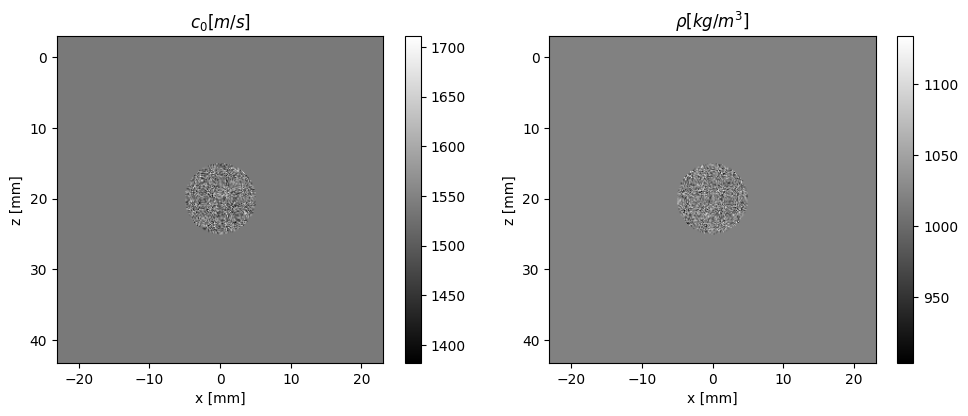

In [5]:
import matplotlib.pyplot as plt
from jwave.geometry import Medium
import numpy

# Transparent background
sound_speed = c0 * np.ones((domain_scan.N_z_axis, domain_scan.N_x_axis))  # [m/s]
density = rho0 * np.ones((domain_scan.N_z_axis, domain_scan.N_x_axis))  # [kg/m3]

# Include hyperechoic cyst
cyst_std = 3 / 100
cx, cz, xr = 0, 20e-3, 5e-3

# NOTE: In the original USTB example, the following variable is called "cn", not "mask".
mask = np.sqrt((domain_scan.x - cx) ** 2 + (domain_scan.z - cz) ** 2) < xr
mask = mask.reshape(sound_speed.shape)
mask = np.transpose(mask, [1, 0])
sound_speed += mask * numpy.random.normal(0, c0*cyst_std, sound_speed.shape)
density += mask * numpy.random.normal(0, density*cyst_std, density.shape)
sound_speed = np.expand_dims(sound_speed, axis=-1)
density = np.expand_dims(density, axis=-1)

medium = Medium(domain, sound_speed, density, pml_size=PML_size)

# Show physical map: speed of sound and density
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
extent = [
    domain_scan.x.min() * 1e3,
    domain_scan.x.max() * 1e3,
    domain_scan.z.max() * 1e3,
    domain_scan.z.min() * 1e3,
]
im0 = ax[0].imshow(sound_speed, cmap="gray", aspect="equal", extent=extent)
fig.colorbar(im0, ax=ax[0])
ax[0].set_title(r"$c_0 [m/s]$")
ax[0].set_xlabel("x [mm]")
ax[0].set_ylabel("z [mm]")
im1 = ax[1].imshow(density, cmap="gray", aspect="equal", extent=extent)
fig.colorbar(im1, ax=ax[1])
ax[1].set_title(r"$\rho [kg/m^3]$")
ax[1].set_xlabel("x [mm]")
ax[1].set_ylabel("z [mm]")
fig.tight_layout()

# Time vector
We define the time vector depending on the CFL number, the size of the domain and the mean speed of sound.

In [6]:
from jwave.geometry import TimeAxis

cfl = 0.3
t_end = 2 * np.sqrt(grid_depth**2 + grid_depth**2) / np.mean(sound_speed)

time_axis = TimeAxis.from_medium(medium, cfl=cfl, t_end=t_end)

In [7]:
from typing import List

from pyuff_ustb import Apodization, Point, Scan, Wave, Window

alpha_max = 1 / 2 / F_number  # Maximum angle span [rad]
angles = np.linspace(-alpha_max, alpha_max, N) if N > 1 else [0]  # Angle vector [rad]
sequence: List[Wave] = []
for n in range(N):
    wave = Wave(
        apodization=Apodization(
            f_number=1,
            window=Window.rectangular,
            focus=Scan(x=0, y=0, z=10e-3),
        ),
        source=Point(azimuth=angles[n], distance=-np.inf),
        probe=probe,
        sound_speed=1540,  # Reference speed of sound [m/s]
    )
    wave.delay = wave.delay_values.min() - cycles / f0
    sequence.append(wave)

/home/magnusk/pyuff/pyuff_ustb/objects/point.py:60: RuntimeWarning: invalid value encountered in scalar multiply
  return self.distance * np.sin(self.elevation)


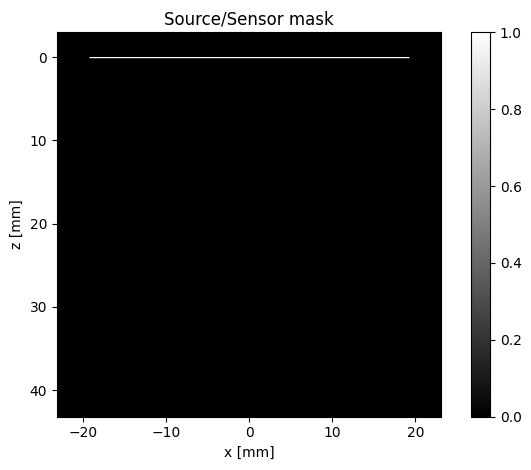

In [8]:
# Find the grid-points that match the element
source_pixels = []
element_sensor_index = []
n = 0
for m in range(probe.N_elements):
    source_i = np.where(
        np.logical_and(
            np.abs(domain_scan.x - probe.x[m]) < (probe.width[m] / 2),
            np.abs(domain_scan.z - probe.z[m]) < (domain_scan.z_step / 2),
        )
    )[0]
    element_i = np.arange(n, n + len(source_i))
    source_i = numpy.unravel_index(
        source_i, (domain_scan.N_z_axis, domain_scan.N_x_axis), "F"
    )
    element_i = numpy.unravel_index(
        element_i, (domain_scan.N_z_axis, domain_scan.N_x_axis), "F"
    )
    source_pixels.append(source_i)
    element_sensor_index.append(element_i)
    n += len(source_pixels[m])

# Sensor mask
sensor_mask = numpy.zeros((domain_scan.N_z_axis, domain_scan.N_x_axis))
for m in range(probe.N_elements):
    sensor_mask[source_pixels[m]] += 1
sensor_mask = np.array(sensor_mask)

# Source mask
source_mask = sensor_mask.copy()

# Show source/sensor mask
fig, ax = plt.subplots()
im = ax.imshow(source_mask, cmap="gray", aspect="equal", extent=extent)
fig.colorbar(im, ax=ax)
ax.set_title("Source/Sensor mask")
ax.set_xlabel("x [mm]")
ax.set_ylabel("z [mm]")
fig.tight_layout()

# Calculation
We are ready to launch the j-Wave calculation :)

In [9]:
import jax
import jax.numpy as jnp
from jwave.acoustics.time_varying import simulate_wave_propagation
from jwave.geometry import Field, Sources
from tqdm import tqdm


def tone_burst(t: jnp.ndarray, f0: float, cycles: int, delay: float):
    gaussian_window = jnp.exp(-0.5 * ((t - delay) / (cycles / f0 / 4)) ** 2)
    sine_wave = jnp.sin(jnp.pi * 2 * f0 * (t - delay))
    return sine_wave * gaussian_window


@jax.jit
def sim1(
    tx_delays: jnp.ndarray,
    source_pixels_x: jnp.ndarray,
    source_pixels_z: jnp.ndarray,
):
    t = jnp.array(time_axis.to_array())
    signals = jnp.stack([tone_burst(t, f0, cycles, delay) for delay in tx_delays])
    signals = jnp.repeat(signals[:, None, :], source_pixels_x.shape[-1], axis=1)
    # Flatten the source pixels and signals
    signals = signals.reshape(-1, signals.shape[-1])
    source_pixels_x_shape = source_pixels_x.shape
    source_pixels_x = source_pixels_x.flatten()
    source_pixels_z = source_pixels_z.flatten()
    sources = Sources(
        positions=(source_pixels_x, source_pixels_z),
        signals=signals,
        dt=time_axis.dt,
        domain=domain,
    )

    def sensor_fn(p: Field, u: Field, rho: Field):
        all_signals = p.on_grid[source_pixels_x, source_pixels_z]
        all_signals = all_signals.reshape(source_pixels_x_shape)
        return jnp.sum(all_signals, -1)

    return simulate_wave_propagation(
        medium,
        time_axis,
        sources=sources,
        sensors=sensor_fn,
    )


print(
    f"Starting simulation of {N} plane waves. You may interrupt the cell to get fewer transmits."
)
data = []
for n in tqdm(range(N)):
    data.append(
        sim1(
            jnp.array(sequence[n].delay_values - sequence[n].delay),
            *np.transpose(np.array(source_pixels), (1, 0, 2)),
        )
    )

Starting simulation of 128 plane waves. You may interrupt the cell to get fewer transmits.


  0%|          | 0/128 [00:00<?, ?it/s]

100%|██████████| 128/128 [00:59<00:00,  2.14it/s]


In [10]:
# Make the data the correct shape for UFF: ("time_samples", "receivers", "transmits")
data = np.transpose(np.nan_to_num(np.array(data)), [1, 2, 0])

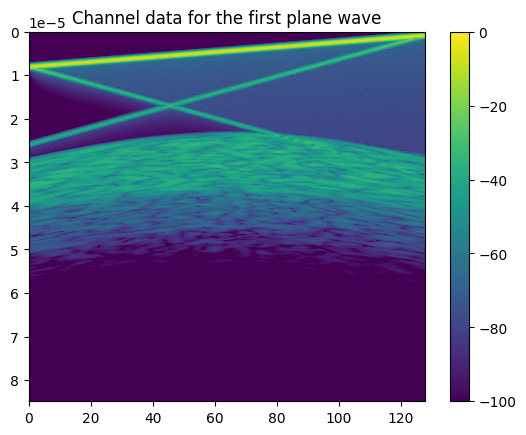

In [11]:
from vbeam.postprocess import normalized_decibels

plt.title("Channel data for the first plane wave")
plt.imshow(
    normalized_decibels(data[..., 0]),
    aspect="auto",
    vmin=-100,
    extent=(0, 128, time_axis.t_end, 0),
)
plt.colorbar()

# Channel data
We can now store the simulated data in a `pyuff_usb.ChannelData object`.

In [12]:
from pyuff_ustb import ChannelData

channel_data = ChannelData(
    sound_speed=1540.0,
    modulation_frequency=0.0,
    probe=probe,
    sequence=sequence[:data.shape[-1]],
    initial_time=0,
    sampling_frequency=1 / time_axis.dt,
    data=data,
)

# Beamforming
To beamform we define a new (coarser) `pyuff_ustb.LinearScan`. We also define and run the beamformer using JAX.

In [13]:
from vbeam.data_importers import import_pyuff
from vbeam.beamformers import get_das_beamformer, get_coherence_beamformer

setup = import_pyuff(channel_data, domain_scan)
setup.apodization.receive.f_number = 0.5
das_beamformer = jax.jit(get_das_beamformer(setup))
coherence_beamformer = jax.jit(get_coherence_beamformer(setup))
bmode = das_beamformer(**setup.data)
coherence = coherence_beamformer(**setup.data)

/home/magnusk/pyuff/pyuff_ustb/objects/point.py:60: RuntimeWarning: invalid value encountered in scalar multiply
  return self.distance * np.sin(self.elevation)


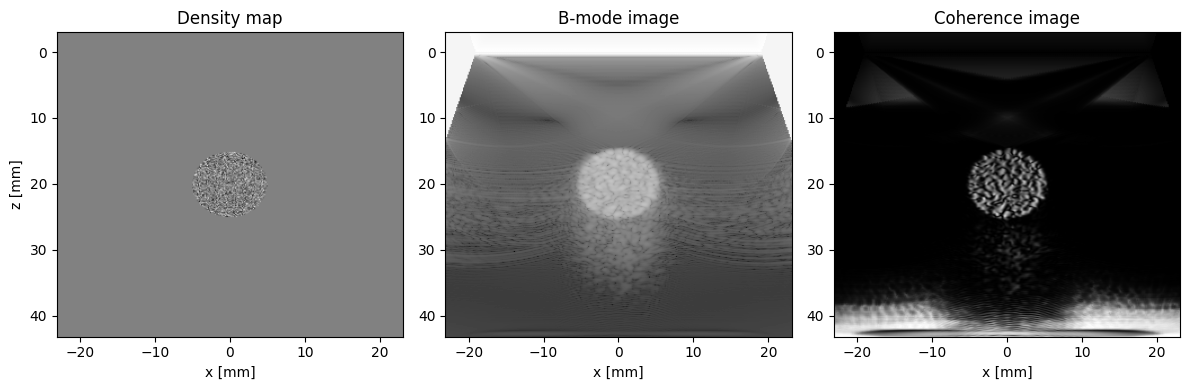

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].imshow(density[..., 0].T, aspect="auto", cmap="gray", extent=extent)
ax[0].set_title("Density map")
ax[1].imshow(bmode.T, aspect="auto", cmap="gray", extent=extent)
ax[1].set_title("B-mode image")
ax[2].imshow(coherence.T, aspect="auto", cmap="gray", extent=extent)
ax[2].set_title("Coherence image")
ax[0].set_ylabel("z [mm]")
for a in ax:
    a.set_xlabel("x [mm]")
fig.tight_layout()

# Store the channel data to disk _(optional)_
Let's write the `pyuff_ustb` data to a file on disk so that we can re-use and share it.

In [15]:
channel_data.write(
    "jwave_cpwc.uff",
    "channel_data",
    overwrite=True,
    ignore_missing_compulsory_fields=True,
)
domain_scan.write("jwave_cpwc.uff", "scan", overwrite=True)